## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [3]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [4]:
data_dir = Path('data')

In [5]:
RETRAIN = True
RESIZE_IMAGES = True

In [6]:
MODEL_NAME='cv_reflect_101_valid'

In [7]:
NB_NUM='03_11_1'

In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: f48f5f1d, DATE: 20191123


In [9]:
#DATE = '20191109'
#UID = '123cca5f'

In [10]:
SUB_NUM='15'

In [11]:
img_size=256

In [12]:
train_images=data_dir/f'train/rotated/clipped/reflect/{img_size}'
test_images=data_dir/f'test/rotated/clipped/reflect/{img_size}'

In [13]:
test_names = get_image_files(test_images)

In [14]:
assert len(test_names)==7325

In [15]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [16]:
len(df_all)

22553

In [17]:
df_valid=df_all.loc[df_all['verified'] == True]

### add St Lucia pred cement as valid

In [18]:
df_sl_cc=pd.read_csv(data_dir/'st_lucia_castries_gold_concrete_cement.csv')

In [19]:
df_sl_cc['roof_material'] = 'concrete_cement'
df_sl_cc['country'] = 'st_lucia'
df_sl_cc['region'] = 'castries'
#pseudo verified
df_sl_cc['verified'] = True

In [20]:
df_valid=df_valid.append(df_sl_cc, ignore_index=True)

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [21]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [22]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [23]:
assert len(df_test)==7325

In [24]:
df_valid.loc[df_valid['id'] == '7a204ec4']

,country,id,region,roof_material,verified
12960,guatemala,7a204ec4,mixco_1_and_ebenezer,irregular_metal,True


In [25]:
len(df_valid)

14945

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [26]:
#xtra_tfms=[dihedral(p=0.5), rand_crop(p=0.4), rand_zoom(scale=(1.,1.5),p=0.4)] 
xtra_tfms=[dihedral(p=0.25), rand_crop(p=0.4)]
tfms = get_transforms(flip_vert=True, max_lighting=0.25, max_zoom=1.2, max_warp=0., xtra_tfms=xtra_tfms)

In [27]:
#tfms = get_transforms(flip_vert=True, max_lighting=0.25, max_zoom=1.2, max_warp=0.)

### setup dataset

In [28]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.1)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

14945


In [29]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [30]:
#to check what params object has
#dir(data)

In [31]:
data.label_list

LabelLists;

Train: LabelList (13451 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (1494 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,concrete_cement,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256

In [32]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

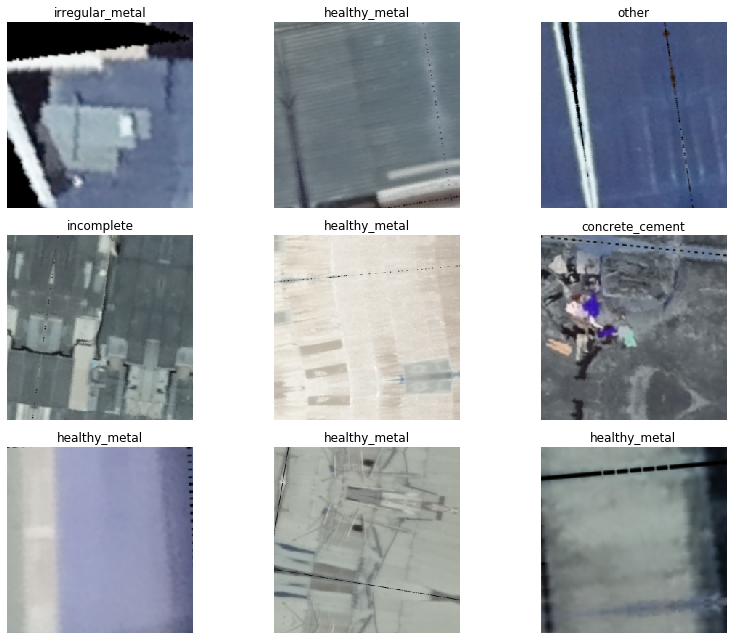

In [33]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [34]:
arch = models.resnet50
arch_name = 'rn50'

In [35]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True)

In [36]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


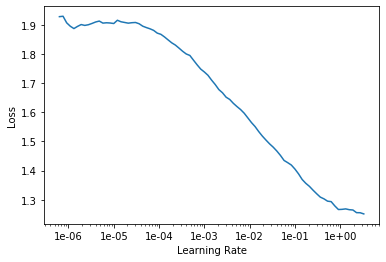

In [38]:
learn.recorder.plot()

Then we can fit the head of our network.

In [39]:
lr = 1e-2

In [40]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.846643,0.690800,0.237617,01:00
1,0.606647,0.539173,0.210843,01:00
2,0.532404,0.506500,0.192102,01:00
3,0.496077,0.485948,0.190763,01:00
4,0.463758,0.481785,0.188086,00:58


In [41]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.490059,0.503282,0.202811,00:57
1,0.485935,0.481546,0.190094,00:56
2,0.476954,0.478212,0.190094,00:56
3,0.456311,0.465066,0.183400,00:55
4,0.430861,0.460968,0.180723,00:56


In [42]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [37]:
print(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

stage-1-rn50-03_11-cv_reflect_101_valid-20191109-123cca5f


In [37]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')
#saves in parent of models directory
#learn.export()

In [37]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilat

In [38]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.470269,0.505857,0.187626,00:47
1,0.471206,0.491431,0.183927,00:48
2,0.426984,0.484390,0.181910,00:48


In [39]:
learn.save(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [52]:
learn.load(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilat

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 191),
 ('healthy_metal', 'irregular_metal', 137),
 ('incomplete', 'irregular_metal', 56),
 ('concrete_cement', 'healthy_metal', 33),
 ('concrete_cement', 'irregular_metal', 19),
 ('incomplete', 'concrete_cement', 16),
 ('irregular_metal', 'incomplete', 16),
 ('other', 'healthy_metal', 13),
 ('healthy_metal', 'concrete_cement', 12),
 ('concrete_cement', 'incomplete', 11),
 ('incomplete', 'healthy_metal', 10),
 ('irregular_metal', 'concrete_cement', 10),
 ('other', 'irregular_metal', 8),
 ('healthy_metal', 'incomplete', 4),
 ('healthy_metal', 'other', 3),
 ('irregular_metal', 'other', 2)]

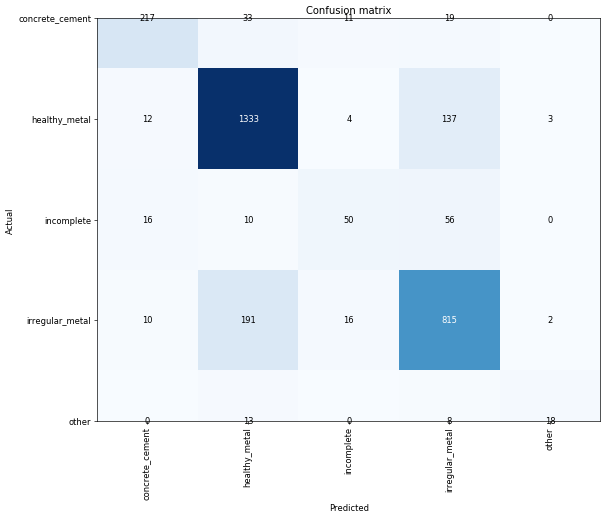

In [54]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [55]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


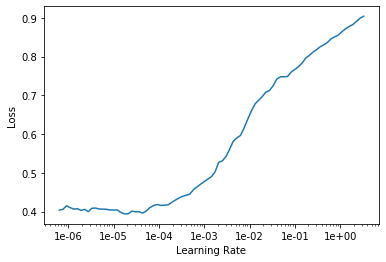

In [56]:
learn.lr_find()
learn.recorder.plot()

In [57]:
learn.fit_one_cycle(5, slice(5e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.439697,0.499175,0.190316,01:02
1,0.461236,0.481513,0.176866,01:02
2,0.403454,0.481539,0.183255,01:03
3,0.354305,0.481688,0.174176,01:03
4,0.302899,0.480282,0.178547,01:04


In [58]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [59]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilat

In [60]:
learn.fit_one_cycle(5, slice(5e-7, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.301765,0.498683,0.181237,01:02
1,0.307908,0.512785,0.182919,01:03
2,0.283382,0.510908,0.182246,01:04
3,0.248251,0.517901,0.181910,01:04
4,0.232628,0.515695,0.180901,01:04


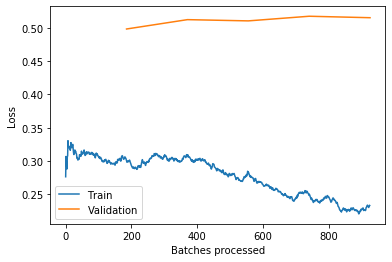

In [61]:
learn.recorder.plot_losses()

In [ ]:
learn.save(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [62]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilat

In [63]:
learn.export()

### inference

In [64]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [65]:
len(test_dataset)

7325

In [66]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [67]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [68]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [69]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [70]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [71]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [72]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [73]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [74]:
labels = np.argmax(preds, 1)

In [75]:
len(preds)

7325

In [76]:
preds[0].tolist()

[0.0629308745265007,
 0.9274115562438965,
 0.001016319845803082,
 0.007238989695906639,
 0.0014022411778569221]

In [77]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [78]:
len(labels)

7325

In [79]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [80]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [81]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [82]:
test_predictions[0]

'healthy_metal'

In [83]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [84]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/reflect/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/reflect/256/7a486800.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4c49fc.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a501f50.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4d27b4.tif')], dtype=object)

In [85]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [86]:
preds_list[0]

[0.0629308745265007,
 0.9274115562438965,
 0.001016319845803082,
 0.007238989695906639,
 0.0014022411778569221]

In [87]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [88]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [89]:
df.head()

,id,pred
0,7a4d9168,"[0.0629308745265007, 0.9274115562438965, 0.001..."
1,7a4ae922,"[0.002035836922004819, 0.9921380877494812, 0.0..."
2,7a48ca98,"[0.0018392581259831786, 0.04761853814125061, 0..."
3,7a49c614,"[0.004468765575438738, 0.6628429889678955, 0.0..."
4,7a4dd4f2,"[0.0023725242353975773, 0.6176864504814148, 0...."


In [90]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [91]:
pred_df.insert(loc=0, column='id', value=ids)

In [92]:
pred_df.columns = cols

In [93]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.062931,0.927412,0.001016,0.007239,0.001402
1,7a4ae922,0.002036,0.992138,0.001046,0.003887,0.000893
2,7a48ca98,0.001839,0.047619,0.014673,0.934436,0.001433
3,7a49c614,0.004469,0.662843,0.002456,0.328902,0.001331
4,7a4dd4f2,0.002373,0.617686,0.002366,0.365965,0.011609


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [94]:
pred_ids=pred_df['id'].values.tolist()

In [95]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [96]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [97]:
baseline_ids=df_baseline['id'].values.tolist()

In [98]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [99]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [100]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.062931,0.927412,0.001016,0.007239,0.001402,7a4d9168
1,7a4ae922,0.002036,0.992138,0.001046,0.003887,0.000893,7a4ae922
2,7a48ca98,0.001839,0.047619,0.014673,0.934436,0.001433,7a48ca98
3,7a49c614,0.004469,0.662843,0.002456,0.328902,0.001331,7a49c614
4,7a4dd4f2,0.002373,0.617686,0.002366,0.365965,0.011609,7a4dd4f2


In [101]:
pred_df=pred_df.sort_values('id_cat')

In [102]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
716,7a4d630a,0.000964,0.991899,0.001250,0.003872,0.002015,7a4d630a
764,7a4bbbd6,0.002175,0.991627,0.000803,0.004684,0.000711,7a4bbbd6
1841,7a4ac744,0.008024,0.417557,0.010922,0.561353,0.002144,7a4ac744
3363,7a4881fa,0.001661,0.018901,0.010896,0.968236,0.000307,7a4881fa
133,7a4aa4a8,0.004693,0.853668,0.002853,0.135639,0.003147,7a4aa4a8


In [103]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [104]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [105]:
### Submission 2: 0.4687


In [106]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

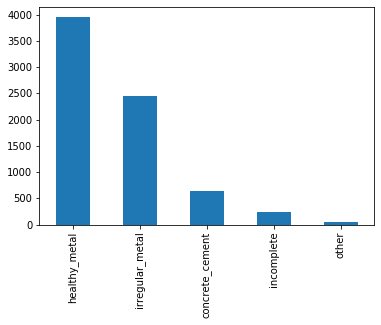

In [107]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")